In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["svg.fonttype"] = "none"

In [4]:
transcript_data = []

with open('genomes/genome_m39/gencode.vM27.chr_patch_hapl_scaff.annotation.gtf', 'r') as gtf_file:
    for line in gtf_file:
        if line.startswith('#'):
            continue

        columns = line.strip().split('\t')
        attributes = columns[8]

        if 'transcript_id' in attributes:
            gene_name = [field for field in attributes.split(';') if 'gene_name' in field][0]
            gene_name = gene_name.split('"')[1]
            gene_id = [field for field in attributes.split(';') if 'gene_id' in field][0]
            gene_id = gene_id.split('"')[1]
            transcript_id = [field for field in attributes.split(';') if 'transcript_id' in field][0]
            transcript_id = transcript_id.split('"')[1]
            gene_type = [field for field in attributes.split(';') if 'gene_type' in field][0]
            gene_type = gene_type.split('"')[1]

            transcript_data.append(columns[:7] + [gene_id] + [gene_name] + [transcript_id] + [gene_type])

column_names = ['seqname', 'source', 'feature', 'start', 'end', 'score', "strand", "gene_id", "gene_name", 'transcript_id', 'gene_type']

annotation = pd.DataFrame(transcript_data, columns=column_names)
annotation['start'] = annotation['start'].astype(int) - 1
annotation = annotation[annotation['feature'] == 'transcript']
annotation

,seqname,source,feature,start,end,score,strand,gene_id,gene_name,transcript_id,gene_type
0,chr1,HAVANA,transcript,3143475,3144545,.,+,ENSMUSG00000102693.2,4933401J01Rik,ENSMUST00000193812.2,TEC
2,chr1,ENSEMBL,transcript,3172238,3172348,.,+,ENSMUSG00000064842.3,Gm26206,ENSMUST00000082908.3,snRNA
4,chr1,HAVANA,transcript,3276123,3286567,.,-,ENSMUSG00000051951.6,Xkr4,ENSMUST00000162897.2,protein_coding
7,chr1,HAVANA,transcript,3276745,3285855,.,-,ENSMUSG00000051951.6,Xkr4,ENSMUST00000159265.2,protein_coding
10,chr1,HAVANA,transcript,3284704,3741721,.,-,ENSMUSG00000051951.6,Xkr4,ENSMUST00000070533.5,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...
1814209,JH584299.1,ENSEMBL,transcript,910288,913083,.,-,ENSMUSG00000095475.2,ENSMUSG00000095475,ENSMUST00000180208.2,protein_coding
1814219,JH584299.1,ENSEMBL,transcript,921941,924675,.,+,ENSMUSG00000094855.2,ENSMUSG00000094855,ENSMUST00000178327.2,protein_coding
1814229,JH584303.1,ENSEMBL,transcript,81606,82689,.,+,ENSMUSG00000095019.2,ENSMUSG00000095019,ENSMUST00000178569.2,protein_coding
1814233,JH584304.1,ENSEMBL,transcript,52189,59667,.,-,ENSMUSG00000095041.8,ENSMUSG00000095041,ENSMUST00000179505.8,protein_coding


In [5]:
def parse_expression_data_tx(path):
    expression_data_tx = pd.read_csv(path, sep="\t").reset_index(drop=True)

    triplets = [
        ('control_diff', 'control_diff_1', 'control_diff_2', 'control_diff_3'),
        ('control_epiSC', 'control_epiSC_1', 'control_epiSC_2', 'control_epiSC_3'),
        ('control_naive', 'control_naive_1', 'control_naive_2', 'control_naive_3'),
        ('oops_diff', 'oops_diff_1', 'oops_diff_2', 'placeholder'),
        ('oops_epiSC', 'oops_epiSC_1', 'oops_epiSC_2', 'oops_epiSC_3'),
        ('oops_naive', 'oops_naive_1', 'oops_naive_2', 'oops_naive_3'),
        ('semi_diff', 'semi_diff_1', 'semi_diff_2', 'semi_diff_3'),
        ('semi_epiSC', 'semi_epiSC_1', 'semi_epiSC_2', 'semi_epiSC_3'),
        ('semi_naive', 'semi_naive_1', 'semi_naive_2', 'semi_naive_3'),
    ]

    expression_data_tx_mean = expression_data_tx[['gene_id']].copy()

    for triplet in triplets:
        name, col1, col2, col3 = triplet
        if col3 == 'placeholder':
            expression_data_tx_mean[f'{name}_mean'] = expression_data_tx[[col1, col2]].mean(axis=1)
        else:
            expression_data_tx_mean[f'{name}_mean'] = expression_data_tx[[col1, col2, col3]].mean(axis=1)
            
    return expression_data_tx_mean

expression_data_tx_path = '/Data/salmon_count_tables/salmon.merged.gene_tpm.tsv'

expression_data_tx = parse_expression_data_tx(expression_data_tx_path)
expression_data_tx["Naive Log2(OOPS/Control)"] = np.log2(expression_data_tx["oops_naive_mean"] / expression_data_tx["control_naive_mean"])
expression_data_tx["EpiSC Log2(OOPS/Control)"] = np.log2(expression_data_tx["oops_epiSC_mean"] / expression_data_tx["control_epiSC_mean"])
expression_data_tx["Diff Log2(OOPS/Control)"] = np.log2(expression_data_tx["oops_diff_mean"] / expression_data_tx["control_diff_mean"])
expression_data_tx["Naive Log2(Semi/Control)"] = np.log2(expression_data_tx["semi_naive_mean"] / expression_data_tx["control_naive_mean"])
expression_data_tx["EpiSC Log2(Semi/Control)"] = np.log2(expression_data_tx["semi_epiSC_mean"] / expression_data_tx["control_epiSC_mean"])
expression_data_tx["Diff Log2(Semi/Control)"] = np.log2(expression_data_tx["semi_diff_mean"] / expression_data_tx["control_diff_mean"])
expression_data_tx

/ceph/hpc/home/novljanj/.conda/envs/tf/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/ceph/hpc/home/novljanj/.conda/envs/tf/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/ceph/hpc/home/novljanj/.conda/envs/tf/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/ceph/hpc/home/novljanj/.conda/envs/tf/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/ceph/hpc/home/novljanj/.conda/envs/tf/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwa

,gene_id,control_diff_mean,control_epiSC_mean,control_naive_mean,oops_diff_mean,oops_epiSC_mean,oops_naive_mean,semi_diff_mean,semi_epiSC_mean,semi_naive_mean,Naive Log2(OOPS/Control),EpiSC Log2(OOPS/Control),Diff Log2(OOPS/Control),Naive Log2(Semi/Control),EpiSC Log2(Semi/Control),Diff Log2(Semi/Control)
0,ENSMUSG00000000001.5,21.178630,18.241482,8.100817,56.611439,55.198251,42.991772,31.163420,30.960366,16.155487,2.407921,1.597400,1.418484,0.995885,0.763200,0.557244
1,ENSMUSG00000000003.16,0.000000,0.024353,0.000000,0.032680,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-inf,inf,NaN,-inf,NaN
2,ENSMUSG00000000028.16,15.166838,15.206390,14.776491,17.179099,17.561817,21.870175,13.999242,16.831587,21.890544,0.565661,0.207764,0.179734,0.567004,0.146493,-0.115572
3,ENSMUSG00000000031.17,0.074661,0.057458,0.027735,0.093334,0.114034,0.063834,0.138456,0.107178,0.125246,1.202610,0.988880,0.322041,2.174989,0.899434,0.890998
4,ENSMUSG00000000037.18,1.955825,0.958104,0.191522,4.600318,2.096712,0.588024,3.774799,1.378180,0.268154,1.618362,1.129875,1.233956,0.485551,0.524511,0.948623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55354,ENSMUSG00002076988.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
55355,ENSMUSG00002076989.1,1.740135,1.644599,9.170797,5.352008,3.643868,7.219729,12.901277,5.800018,8.145021,-0.345102,1.147735,1.620881,-0.171129,1.818322,2.890242
55356,ENSMUSG00002076990.1,9.188771,15.389314,3.447507,34.602337,21.442325,0.000000,31.946262,20.182100,0.000000,-inf,0.478532,1.912926,-inf,0.391147,1.797703
55357,ENSMUSG00002076991.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.462648,0.000000,0.000000,0.000000,inf,NaN,NaN,NaN,NaN,NaN


In [6]:
masterfile = pd.read_csv('Data/masterfile/all_smOOPS_and_controls_V2.tsv', sep='\t')
masterfile_with_expression = pd.merge(masterfile, expression_data_tx, left_on='gene_id', right_on='gene_id', how='inner')
masterfile_with_expression

,chr,start,end,gene_id,feature,strand,gene_name,transcript_id,feature_length,smoops_naive,...,oops_naive_mean,semi_diff_mean,semi_epiSC_mean,semi_naive_mean,Naive Log2(OOPS/Control),EpiSC Log2(OOPS/Control),Diff Log2(OOPS/Control),Naive Log2(Semi/Control),EpiSC Log2(Semi/Control),Diff Log2(Semi/Control)
0,chr1,3284704,3741721,ENSMUSG00000051951.6,transcript,-,Xkr4,ENSMUST00000070533.5,457017,False,...,0.041081,3.872970,2.324972,0.014051,2.565464,4.147659,3.634499,1.017631,2.570854,2.488696
1,chr1,3435953,3438772,ENSMUSG00000103377.2,transcript,-,Gm37180,ENSMUST00000195335.2,2819,False,...,0.021397,0.521827,0.301747,0.012481,1.502542,7.088817,6.059440,0.724828,4.009559,3.589189
2,chr1,3445778,3448011,ENSMUSG00000104017.2,transcript,-,Gm37363,ENSMUST00000192336.2,2233,False,...,0.036707,0.485116,0.206451,0.000000,inf,8.386407,6.823165,NaN,4.410430,3.970319
3,chr1,3535199,3537508,ENSMUSG00000103025.2,transcript,-,Gm37686,ENSMUST00000194099.2,2309,False,...,0.000000,0.627143,0.321620,0.000000,-inf,3.988775,3.624047,-inf,2.392433,3.078357
4,chr1,3582673,3584730,ENSMUSG00000103201.2,transcript,-,Gm37329,ENSMUST00000192973.2,2057,False,...,0.000000,1.040409,0.393665,0.000000,NaN,4.956382,4.341127,NaN,3.072409,3.260426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,chrX,160616291,160942726,ENSMUSG00000059493.14,transcript,-,Nhs,ENSMUST00000087085.10,326435,False,...,0.313898,0.707368,0.917609,0.077997,3.678835,4.843511,4.523886,1.670035,3.093538,3.013968
3056,chrX,165173028,165223700,ENSMUSG00000040586.9,transcript,-,Ofd1,ENSMUST00000049501.9,50672,False,...,10.964003,2.596442,2.308879,1.399653,4.451630,4.274300,3.997390,1.481997,2.361746,2.502965
3057,chrX,168094525,168103276,ENSMUSG00000031352.11,transcript,-,Hccs,ENSMUST00000033717.9,8751,False,...,16.648515,8.779636,9.323919,9.318443,1.832709,1.107688,0.908165,0.995477,0.691183,0.533826
3058,chrY,1260770,1286629,ENSMUSG00000069045.12,transcript,-,Ddx3y,ENSMUST00000091190.12,25859,False,...,27.669775,12.061610,9.830595,1.813766,4.853758,4.341627,4.052005,0.922507,2.518751,2.587359


In [7]:
clusters = pd.read_csv('Results/machine_learning_results/cluster_assignment_file/cluster_of_all_model.tsv', sep='\t')
masterfile_with_expression_with_clusters = pd.merge(masterfile_with_expression, clusters, left_on='transcript_id', right_on='transcript_id', how='inner')
pd.set_option('display.max_columns', None)
masterfile_with_expression_with_clusters

,chr,start,end,gene_id,feature,strand,gene_name,transcript_id,feature_length,smoops_naive,smoops_epi,smoops_diff,control_common,semi_diff_mean_tpm,semi_epiSC_mean_tpm,semi_naive_mean_tpm,semi_diff_mean_count,semi_epiSC_mean_count,semi_naive_mean_count,control_diff_mean,control_epiSC_mean,control_naive_mean,oops_diff_mean,oops_epiSC_mean,oops_naive_mean,semi_diff_mean,semi_epiSC_mean,semi_naive_mean,Naive Log2(OOPS/Control),EpiSC Log2(OOPS/Control),Diff Log2(OOPS/Control),Naive Log2(Semi/Control),EpiSC Log2(Semi/Control),Diff Log2(Semi/Control),Cluster
0,chr1,3284704,3741721,ENSMUSG00000051951.6,transcript,-,Xkr4,ENSMUST00000070533.5,457017,False,True,True,False,3.872970,2.324972,0.014051,194.333000,235.666667,0.666667,0.690036,0.391303,0.006940,8.569689,6.935587,0.041081,3.872970,2.324972,0.014051,2.565464,4.147659,3.634499,1.017631,2.570854,2.488696,0
1,chr1,3435953,3438772,ENSMUSG00000103377.2,transcript,-,Gm37180,ENSMUST00000195335.2,2819,False,True,True,False,0.521827,0.301747,0.012481,22.666667,26.666667,0.333333,0.043358,0.018735,0.007552,2.891650,2.550307,0.021397,0.521827,0.301747,0.012481,1.502542,7.088817,6.059440,0.724828,4.009559,3.589189,1
2,chr1,3445778,3448011,ENSMUSG00000104017.2,transcript,-,Gm37363,ENSMUST00000192336.2,2233,False,False,True,False,0.485116,0.206451,0.000000,14.333333,15.666667,0.000000,0.030950,0.009708,0.000000,3.504596,3.248664,0.036707,0.485116,0.206451,0.000000,inf,8.386407,6.823165,NaN,4.410430,3.970319,1
3,chr1,3535199,3537508,ENSMUSG00000103025.2,transcript,-,Gm37686,ENSMUST00000194099.2,2309,False,False,True,False,0.627143,0.321620,0.000000,18.000000,24.666667,0.000000,0.074249,0.061256,0.005198,0.915452,0.972500,0.000000,0.627143,0.321620,0.000000,-inf,3.988775,3.624047,-inf,2.392433,3.078357,1
4,chr1,3582673,3584730,ENSMUSG00000103201.2,transcript,-,Gm37329,ENSMUST00000192973.2,2057,False,False,True,False,1.040409,0.393665,0.000000,30.333333,25.333333,0.000000,0.108572,0.046799,0.000000,2.200530,1.452979,0.000000,1.040409,0.393665,0.000000,NaN,4.956382,4.341127,NaN,3.072409,3.260426,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,chrX,158315663,158376077,ENSMUSG00000044150.13,transcript,+,Bclaf3,ENSMUST00000112464.8,60414,False,True,True,False,7.689802,6.577402,11.816828,175.999333,311.999667,228.218000,1.721322,1.457148,3.991728,17.117202,19.095110,99.769401,7.689802,6.577402,11.816828,4.643512,3.711984,3.313858,1.565758,2.174371,2.159430,1
1820,chrX,160616291,160942726,ENSMUSG00000059493.14,transcript,-,Nhs,ENSMUST00000087085.10,326435,False,True,True,False,0.707368,0.917609,0.077997,91.000000,245.000000,6.000000,0.087569,0.107500,0.024510,2.014539,3.086398,0.313898,0.707368,0.917609,0.077997,3.678835,4.843511,4.523886,1.670035,3.093538,3.013968,0
1821,chrX,165173028,165223700,ENSMUSG00000040586.9,transcript,-,Ofd1,ENSMUST00000049501.9,50672,False,True,True,False,2.596442,2.308879,1.399653,165.333333,326.725000,86.666667,0.458048,0.449205,0.501066,7.315521,8.692353,10.964003,2.596442,2.308879,1.399653,4.451630,4.274300,3.997390,1.481997,2.361746,2.502965,1
1822,chrY,1260770,1286629,ENSMUSG00000069045.12,transcript,-,Ddx3y,ENSMUST00000091190.12,25859,False,True,True,False,12.061610,9.830595,1.813766,633.994667,1141.029333,96.344667,2.006932,1.715379,0.956927,33.289537,34.779245,27.669775,12.061610,9.830595,1.813766,4.853758,4.341627,4.052005,0.922507,2.518751,2.587359,1


In [8]:
masterfile_with_expression_with_clusters_and_annotation = pd.merge(masterfile_with_expression_with_clusters, annotation, left_on='transcript_id', right_on='transcript_id', how='inner')
masterfile_with_expression_with_clusters_and_annotation

,chr,start_x,end_x,gene_id_x,feature_x,strand_x,gene_name_x,transcript_id,feature_length,smoops_naive,smoops_epi,smoops_diff,control_common,semi_diff_mean_tpm,semi_epiSC_mean_tpm,semi_naive_mean_tpm,semi_diff_mean_count,semi_epiSC_mean_count,semi_naive_mean_count,control_diff_mean,control_epiSC_mean,control_naive_mean,oops_diff_mean,oops_epiSC_mean,oops_naive_mean,semi_diff_mean,semi_epiSC_mean,semi_naive_mean,Naive Log2(OOPS/Control),EpiSC Log2(OOPS/Control),Diff Log2(OOPS/Control),Naive Log2(Semi/Control),EpiSC Log2(Semi/Control),Diff Log2(Semi/Control),Cluster,seqname,source,feature_y,start_y,end_y,score,strand_y,gene_id_y,gene_name_y,gene_type
0,chr1,3284704,3741721,ENSMUSG00000051951.6,transcript,-,Xkr4,ENSMUST00000070533.5,457017,False,True,True,False,3.872970,2.324972,0.014051,194.333000,235.666667,0.666667,0.690036,0.391303,0.006940,8.569689,6.935587,0.041081,3.872970,2.324972,0.014051,2.565464,4.147659,3.634499,1.017631,2.570854,2.488696,0,chr1,HAVANA,transcript,3284704,3741721,.,-,ENSMUSG00000051951.6,Xkr4,protein_coding
1,chr1,3435953,3438772,ENSMUSG00000103377.2,transcript,-,Gm37180,ENSMUST00000195335.2,2819,False,True,True,False,0.521827,0.301747,0.012481,22.666667,26.666667,0.333333,0.043358,0.018735,0.007552,2.891650,2.550307,0.021397,0.521827,0.301747,0.012481,1.502542,7.088817,6.059440,0.724828,4.009559,3.589189,1,chr1,HAVANA,transcript,3435953,3438772,.,-,ENSMUSG00000103377.2,Gm37180,TEC
2,chr1,3445778,3448011,ENSMUSG00000104017.2,transcript,-,Gm37363,ENSMUST00000192336.2,2233,False,False,True,False,0.485116,0.206451,0.000000,14.333333,15.666667,0.000000,0.030950,0.009708,0.000000,3.504596,3.248664,0.036707,0.485116,0.206451,0.000000,inf,8.386407,6.823165,NaN,4.410430,3.970319,1,chr1,HAVANA,transcript,3445778,3448011,.,-,ENSMUSG00000104017.2,Gm37363,TEC
3,chr1,3535199,3537508,ENSMUSG00000103025.2,transcript,-,Gm37686,ENSMUST00000194099.2,2309,False,False,True,False,0.627143,0.321620,0.000000,18.000000,24.666667,0.000000,0.074249,0.061256,0.005198,0.915452,0.972500,0.000000,0.627143,0.321620,0.000000,-inf,3.988775,3.624047,-inf,2.392433,3.078357,1,chr1,HAVANA,transcript,3535199,3537508,.,-,ENSMUSG00000103025.2,Gm37686,TEC
4,chr1,3582673,3584730,ENSMUSG00000103201.2,transcript,-,Gm37329,ENSMUST00000192973.2,2057,False,False,True,False,1.040409,0.393665,0.000000,30.333333,25.333333,0.000000,0.108572,0.046799,0.000000,2.200530,1.452979,0.000000,1.040409,0.393665,0.000000,NaN,4.956382,4.341127,NaN,3.072409,3.260426,1,chr1,HAVANA,transcript,3582673,3584730,.,-,ENSMUSG00000103201.2,Gm37329,TEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,chrX,158315663,158376077,ENSMUSG00000044150.13,transcript,+,Bclaf3,ENSMUST00000112464.8,60414,False,True,True,False,7.689802,6.577402,11.816828,175.999333,311.999667,228.218000,1.721322,1.457148,3.991728,17.117202,19.095110,99.769401,7.689802,6.577402,11.816828,4.643512,3.711984,3.313858,1.565758,2.174371,2.159430,1,chrX,HAVANA,transcript,158315663,158376077,.,+,ENSMUSG00000044150.13,Bclaf3,protein_coding
1820,chrX,160616291,160942726,ENSMUSG00000059493.14,transcript,-,Nhs,ENSMUST00000087085.10,326435,False,True,True,False,0.707368,0.917609,0.077997,91.000000,245.000000,6.000000,0.087569,0.107500,0.024510,2.014539,3.086398,0.313898,0.707368,0.917609,0.077997,3.678835,4.843511,4.523886,1.670035,3.093538,3.013968,0,chrX,HAVANA,transcript,160616291,160942726,.,-,ENSMUSG00000059493.14,Nhs,protein_coding
1821,chrX,165173028,165223700,ENSMUSG00000040586.9,transcript,-,Ofd1,ENSMUST00000049501.9,50672,False,True,True,False,2.596442,2.308879,1.399653,165.333333,326.725000,86.666667,0.458048,0.449205,0.501066,7.315521,8.692353,10.964003,2.596442,2.308879,1.399653,4.451630,4.274300,3.997390,1.481997,2.361746,2.502965,1,chrX,HAVANA,transcript,165173028,165223700,.,-,ENSMUSG00000040586.9,Ofd1,protein_coding
1822,chrY,1260770,1286629,ENSMUSG00000069045.12

min, max:  -2.33569381575717 6.918028247346388


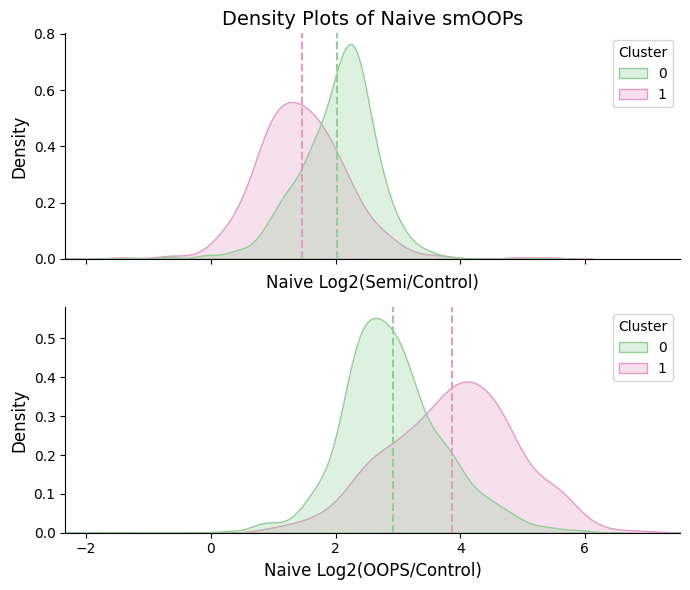

min, max:  0.2643019209482285 7.52580981951687


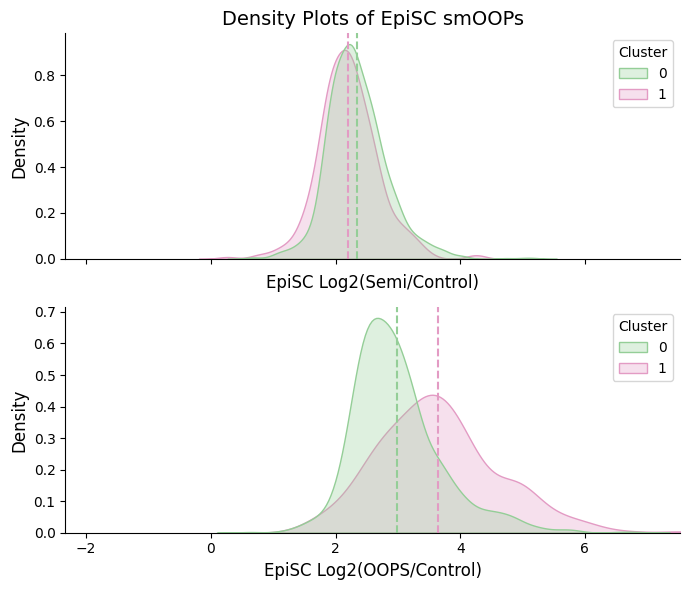

min, max:  -0.5214807236730103 7.328844890603574


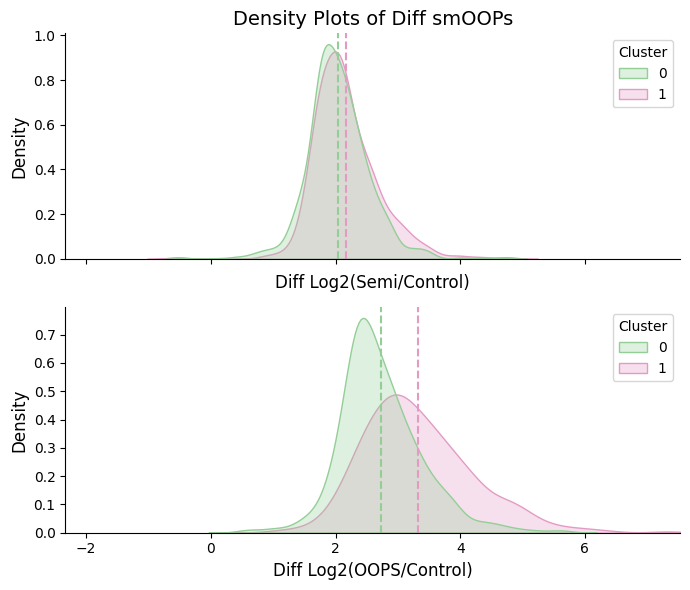

In [23]:
def plot_vertical_density(data, x_col, y_col, category_col, cluster_colors, stage):

    data = data.copy()
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data[[x_col, y_col, category_col]].dropna()

    x_min = data[x_col].min()
    x_max = data[x_col].max()
    y_min = data[y_col].min()
    y_max = data[y_col].max()

    min = np.min([x_min, y_min])
    max = np.max([x_max, y_max])
    
    print("min, max: ", min, max)
    min = -2.33569381575717
    max = 7.52580981951687

    fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=False)

    sns.kdeplot(
        data=data,
        x=x_col,
        hue=category_col,
        palette=cluster_colors,
        fill=True,
        common_norm=False,
        alpha=0.3,
        ax=axes[0]
    )

    axes[0].set_title(f"Density Plots of {stage} smOOPs", fontsize=14)
    axes[0].set_xlabel(x_col, fontsize=12)
    axes[0].set_ylabel("Density", fontsize=12)
    axes[0].tick_params(axis="both", labelsize=10)
    axes[0].set_xlim(min, max)
    axes[0].set_xticklabels([])

    sns.kdeplot(
        data=data,
        x=y_col,
        hue=category_col,
        palette=cluster_colors,
        fill=True,
        common_norm=False,
        alpha=0.3,
        ax=axes[1]
    )

    for category in data[category_col].unique():
        subset = data[data[category_col] == category]
        x_mean = subset[x_col].mean()
        y_mean = subset[y_col].mean()
        axes[0].axvline(x_mean, color=cluster_colors[category], linestyle="--", label=f"{category} mean")
        axes[1].axvline(y_mean, color=cluster_colors[category], linestyle="--", label=f"{category} mean")

    axes[1].set_xlabel(y_col, fontsize=12)
    axes[1].set_ylabel("Density", fontsize=12)
    axes[1].tick_params(axis="both", labelsize=10)
    axes[1].set_xlim(min, max)
    sns.despine()
    plt.tight_layout()
    plt.show()

cluster_colors = {
    0: '#94CE97', 
    1: '#E39BC4' 
}

for i in ["Naive", "EpiSC", "Diff"]:
    if i == "Naive":
        name_smoops = "smoops_naive"
    elif i == "EpiSC":
        name_smoops = "smoops_epi"
    else:
        name_smoops = "smoops_diff"    
        
    plot_vertical_density(
        masterfile_with_expression_with_clusters_and_annotation[(masterfile_with_expression_with_clusters_and_annotation["gene_type"] == "protein_coding")],
        f'{i} Log2(Semi/Control)',
        f'{i} Log2(OOPS/Control)',
        'Cluster',
        cluster_colors,
        i
    )

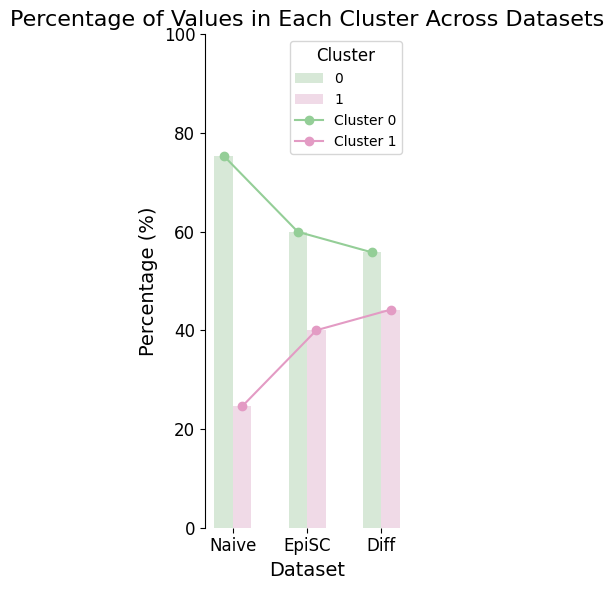

In [21]:
def plot_cluster_percentages_bar(data_list, category_col, cluster_colors, common_title=None):

    percentages = []
    for i, data in enumerate(data_list):
        if i == 0:
            i = "Naive"
        if i == 1:
            i = "EpiSC"
        if i == 2:
            i = "Diff"
        counts = data[category_col].value_counts(normalize=True) * 100
        for cluster, percent in counts.items():
            percentages.append({'Dataset': f'{i}', 'Cluster': cluster, 'Percentage': percent})

    percentages_df = pd.DataFrame(percentages)

    plt.figure(figsize=(3, 6))
    barplot = sns.barplot(
        data=percentages_df,
        x="Dataset",
        y="Percentage",
        hue="Cluster",
        palette=cluster_colors,
        dodge=True,
        width=0.5,
        alpha=0.4
    )

    cluster_0_x = []
    cluster_1_x = []
    for i, bar in enumerate(barplot.patches):
        if i ==6:
            break
        if i < 3:
            cluster_0_x.append(bar.get_x() + bar.get_width() / 2)
        else:
            cluster_1_x.append(bar.get_x() + bar.get_width() / 2)

    plt.plot(cluster_0_x, percentages_df[percentages_df['Cluster'] == 0]['Percentage'], marker='o', label='Cluster 0', color=cluster_colors[0])
    plt.plot(cluster_1_x, percentages_df[percentages_df['Cluster'] == 1]['Percentage'], marker='o', label='Cluster 1', color=cluster_colors[1])

    plt.xlabel("Dataset", fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.title(common_title if common_title else "Cluster Percentages Across Datasets", fontsize=16)
    plt.legend(title="Cluster", fontsize=10, title_fontsize=12)
    sns.despine(left=False, bottom=True, top=True, right=True)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

data_list = [
    masterfile_with_expression_with_clusters[masterfile_with_expression_with_clusters["smoops_naive"] == True],
    masterfile_with_expression_with_clusters[masterfile_with_expression_with_clusters["smoops_epi"] == True],
    masterfile_with_expression_with_clusters[masterfile_with_expression_with_clusters["smoops_diff"] == True]
]

plot_cluster_percentages_bar(
    data_list,
    category_col='Cluster',
    cluster_colors=cluster_colors,
    common_title="Percentage of Values in Each Cluster Across Datasets"
)